In [1]:
import numpy as np 
import pandas as pd 
import math
import random
import matplotlib.pyplot as plt
import time
from numpy.linalg import slogdet, det, solve
from sklearn.datasets import load_digits
from sklearn.mixture.base import BaseMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal as mvn
from sklearn.mixture import GaussianMixture
from scipy import linalg

### Data Extraction

In [2]:
cho = pd.read_csv('cho.txt', header = None, delimiter="\t")
iyer = pd.read_csv('iyer.txt', header = None, delimiter="\t")
cluster = cho[1]
cluster2 = iyer[1]
X = cho.iloc[:, 2:]
X = X.to_numpy()
Y = iyer.iloc[:, 2:]
Y = Y.to_numpy()
cluster = cluster.to_numpy()
clusterY = cluster2.to_numpy()

## Library Implementation

In [3]:
def LibraryGMM(n_components, X):
    gmm = GaussianMixture(n_components, covariance_type='full').fit(X)
    prediction_gmm = gmm.predict(X)
    probs = gmm.predict_proba(X)
    assigned_cluster = prediction_gmm.reshape((X.shape[0],1)) 
    pca_data = PCA(n_components = 2).fit_transform(X)
    finalDf = np.concatenate((pca_data, assigned_cluster), axis = 1)
    finalDf = pd.DataFrame({'Component1': finalDf[:, 0], 'Component2': finalDf[:, 1], 'Target': finalDf[:, 2]})
    return finalDf

In [4]:
def drawGraph(finalDf, size):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('Library PCA', fontsize = 20)
    targets = [i for i in range(size)]
    colors  = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(size)]
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['Target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'Component1'], finalDf.loc[indicesToKeep, 'Component2'], c = color, s = 50)
    ax.legend(targets)
    ax.grid()

# Cho

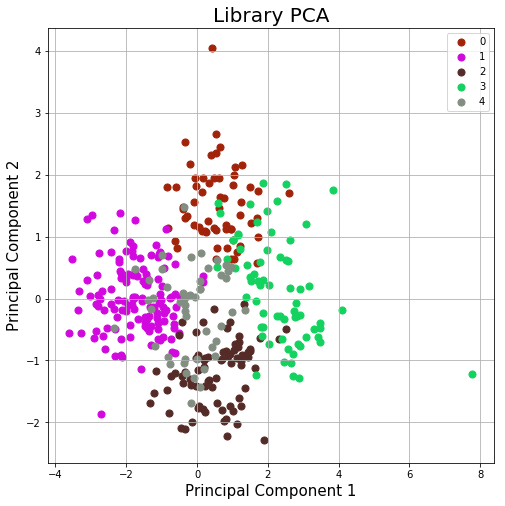

In [5]:
finalDf = LibraryGMM(5, X)
drawGraph(finalDf, 5)

# Iyer

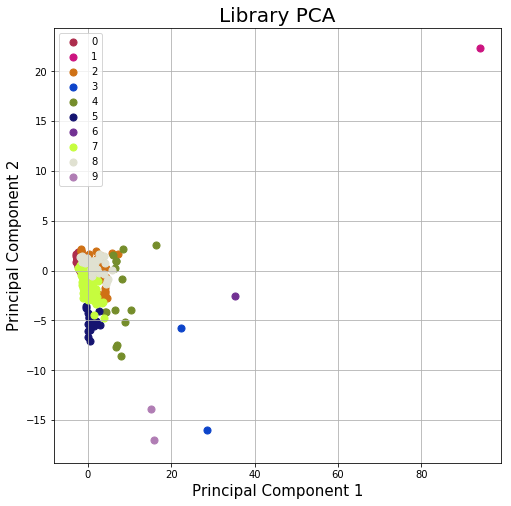

In [6]:
finalDf = LibraryGMM(10, Y)
drawGraph(finalDf, 10)

## Scratch Implementation

In [5]:
class GMM:
    def __init__(self, C, n_runs, X):
        """
        pi: (C)
        mu: (C x f)
        sigma: (C x f x f)
        gamma: (d x C), probabilities of clusters for objects
        """
        self.C = C
        self.n_runs = n_runs
        self.d = X.shape[0] # rows of data
        self.f = X.shape[1] # Feature of data
        
        self.mu = np.zeros((self.C, self.f))
        self.sigma = np.zeros((self.C, self.f, self.f))
        self.gamma = np.zeros((self.d, self.C))
        self.pi = np.zeros(self.C)
        ## ------- Set Value using Kmeans ----------------------------------
        kmeans = KMeans(n_clusters= C, init="k-means++", max_iter=500, algorithm = 'auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)        
        labels = np.unique(prediction)
        counter=0
        for label in labels:
            ids = np.where(prediction == label) # returns indices
            self.pi[counter] = len(ids[0]) / X.shape[0]
            self.mu[counter] = np.mean(X[ids], axis = 0)
            de_meaned = X[ids] - self.mu[counter,:]
            Nk = X[ids].shape[0] # number of data points in current gaussian
            self.sigma[counter,:, :] = np.dot(self.pi[counter] * de_meaned.T, de_meaned) / Nk
            counter += 1
        ## ------------End --------------------------------------------------    
        #for i in range(C):
        #    P = X[int(self.d/C*i) : int(self.d/C*(i+1))]
        #    self.sigma[i] = np.cov(P.T)
    
    def MuSigmaPi(self, mu, sigma, pi):
        self.mu = mu
        self.sigma = sigma
        self.pi = pi

    def fit(self, X, threshold, smooth):
        mu, pi, sigma = self.mu, self.pi, self.sigma 
        prev_loss = 0
        for run in range(self.n_runs):  
            self.gamma  = self._e_step(X, mu, pi, sigma, smooth)
            pi, mu, sigma = self._m_step(X, self.gamma)
            loss = self.likelihood_function(X, pi, mu, sigma)
            if abs(loss - prev_loss) < threshold:
                print("Loss below threshold. Iteration: %d Loss: %0.6f" %(run, loss))
                return self
            if run % 10 == 0:
                print("Iteration: %d Loss: %0.6f" %(run, loss))
            prev_loss = loss
        return self
    
    def _e_step(self, X, mu, pi, sigma, smooth):
        
        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            try:
                mvn.pdf(X, self.mu[c,:], self.sigma[c])
            except:
                #print('Hello')
                #print(self.sigma[c][np.diag_indices(self.sigma[c].shape[0])])
                self.sigma[c][np.diag_indices(self.sigma[c].shape[0])] =  self.sigma[c][np.diag_indices_from(self.sigma[c])] + smooth
            #print(self.sigma[c])
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c])

        # normalize across columns to make a valid probability
        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm
        return self.gamma
    
    def _m_step(self, X, gamma):
        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)
        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]

        for c in range(self.C):
            x = X - self.mu[c, :] # (N x d) 
            gamma_diag = np.diag(self.gamma[:,c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)
            sigma_c = x.T * gamma_diag * x
            self.sigma[c]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma
    
    
    def likelihood_function(self, X, pi, mu, sigma):        
        self.loss = np.zeros((self.d, self.C))
        for c in range(self.C):
            dist = mvn(self.mu[c], self.sigma[c],allow_singular=True)
            self.loss[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X)-np.log(self.gamma[:,c]+0.000001))
        self.loss = np.sum(self.loss)
        return self.loss
 
    def predict(self, X):
        labels = np.zeros((X.shape[0], self.C))
        labels  = self.gamma.argmax(1)
        return labels 
    

In [6]:
def scratchGmm(n_components, n_runs, X, threshold, smooth = 0.0001, define = False, mu = 0, sigma = 0, pi = 0):
    model = GMM(n_components, n_runs, X)
    if define:
        model.MuSigmaPi(mu, sigma, pi)
    fitted_values = model.fit(X, threshold, smooth)
    predicted_values = model.predict(X)
    assigned_cluster = predicted_values.reshape((X.shape[0],1)) 
    pca_data = PCA(n_components = 2).fit_transform(X)
    finalDf = np.concatenate((pca_data, assigned_cluster), axis = 1)
    finalDf = pd.DataFrame({'Component1': finalDf[:, 0], 'Component2': finalDf[:, 1], 'Target': finalDf[:, 2]})
    return finalDf, assigned_cluster

## Jaccard and Rand coefficients

In [7]:
def JaccardRand(cluster, assigned_cluster):
    ground_truth_matrix = np.zeros((len(assigned_cluster),len(assigned_cluster)))
    incidence_matrix = np.zeros((len(assigned_cluster),len(assigned_cluster)))

    for i in range(len(assigned_cluster)):
        for j in range(len(assigned_cluster)):
            ground_truth_matrix[i][j] = 1 if (assigned_cluster[i]==assigned_cluster[j]) else 0
            incidence_matrix[i][j] = 1 if (cluster[i]==cluster[j]) else 0
            
    m_1_1 = m_0_0 = m_1_0 = m_0_1 = 0.0
    for i in range(len(ground_truth_matrix)):
        for j in range(len(ground_truth_matrix)):
            if ground_truth_matrix[i][j] == incidence_matrix[i][j]:
                if ground_truth_matrix[i][j] == 1:
                    m_1_1 += 1
                else:
                    m_0_0 += 1
            else:
                if ground_truth_matrix[i][j] == 1:
                    m_1_0 += 1
                else:
                    m_0_1 += 1


    Jaccard = str(m_1_1 / (m_1_1 + m_1_0 + m_0_1))  
    Rand = str((m_1_1 + m_0_0) / (m_1_1 + m_0_0 + m_1_0 + m_0_1))
    print(f"The RAND coefficient is: {Rand}")
    print(f"The JACCARD coefficient is: {Jaccard}")

# Cho

Iteration: 0 Loss: -1335.942405
Iteration: 10 Loss: -1249.441787
Iteration: 20 Loss: -1247.046561
Iteration: 30 Loss: -1247.045782
Loss below threshold. Iteration: 38 Loss: -1247.045781


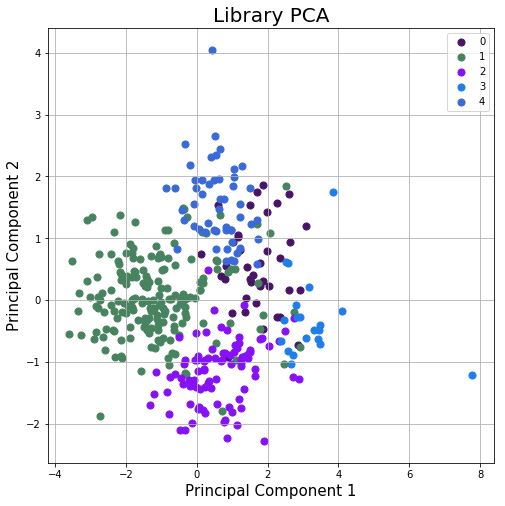

In [10]:
finalDf, assigned_clusterX = scratchGmm(5, 100, X, 1e-08)
drawGraph(finalDf, 5)

In [11]:
JaccardRand(cluster, assigned_clusterX)

The RAND coefficient is: 0.7474563075518806
The JACCARD coefficient is: 0.3684033839129851


# Iyer

Iteration: 0 Loss: -1147.297791
Iteration: 10 Loss: -756.397685
Iteration: 20 Loss: -738.627384
Iteration: 30 Loss: -738.613988
Iteration: 40 Loss: -738.613214
Iteration: 50 Loss: -738.613194
Iteration: 60 Loss: -738.613209
Iteration: 70 Loss: -738.613216
Iteration: 80 Loss: -738.613218
Iteration: 90 Loss: -738.613218
Loss below threshold. Iteration: 99 Loss: -738.613218


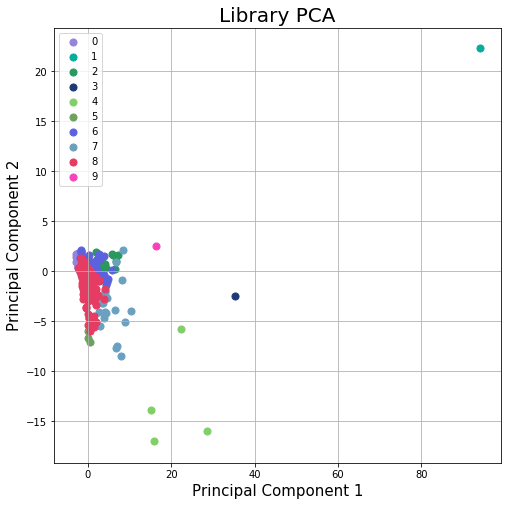

In [12]:
finalDf, assigned_clusterY = scratchGmm(10, 100, Y, 1e-08)

drawGraph(finalDf, 10)

In [13]:
JaccardRand(clusterY, assigned_clusterY)

The RAND coefficient is: 0.7478309994051383
The JACCARD coefficient is: 0.34097286726961623


### GMM.txt

In [10]:
def scratchGmm_NoPCA(n_components, n_runs, X, threshold, smooth = 0.0001, define = False, mu = 0, sigma = 0, pi = 0):
    model = GMM(n_components, n_runs, X)
    if define:
        model.MuSigmaPi(mu, sigma, pi)
    fitted_values = model.fit(X, threshold, smooth)
    predicted_values = model.predict(X)
    assigned_cluster = predicted_values.reshape((X.shape[0],1)) 
    #pca_data = PCA(n_components = 2).fit_transform(X)
    finalDf = np.concatenate((X, assigned_cluster), axis = 1)
    finalDf = pd.DataFrame({'Component1': finalDf[:, 0], 'Component2': finalDf[:, 1], 'Target': finalDf[:, 2]})
    print('Model Sigma:')
    print(model.sigma)
    print('Model Pi:')
    print(model.pi)
    print('Model mu:')
    print(model.mu)
    return finalDf, assigned_cluster

In [8]:
mu =[[0, 0], [3, 3], [0,4]]
sigma = [[[1,0.4], [0.4,1]], [[1,0], [0,2]], [[0.4, 0], [0,0.1]]]
pi = [0.4, 0.4, 0.2] 
clu = 3 
threshold = 1e-9
maximum_iterations = 100
smoothing = 1e-9
mu = np.asarray(mu, dtype=np.float64)
sigma = np.asarray(sigma, dtype=np.float64)
pi = np.asarray(pi, dtype=np.float64)

Iteration: 0 Loss: -1747.576130
Iteration: 10 Loss: -1747.504259
Iteration: 20 Loss: -1747.504216
Loss below threshold. Iteration: 30 Loss: -1747.504216
Model Sigma:
[[[ 0.92965605  0.37932413]
  [ 0.37932413  0.84677438]]

 [[ 0.96222988 -0.03618241]
  [-0.03618241  1.60614448]]

 [[ 0.46059821 -0.06042024]
  [-0.06042024  0.1063243 ]]]
Model Pi:
[0.40371523 0.39629726 0.19998752]
Model mu:
[[ 8.51085267e-03 -2.38024022e-03]
 [ 3.03124687e+00  3.00615132e+00]
 [-1.70409969e-02  3.95339080e+00]]
The RAND coefficient is: 0.95208
The JACCARD coefficient is: 0.8733561672798004


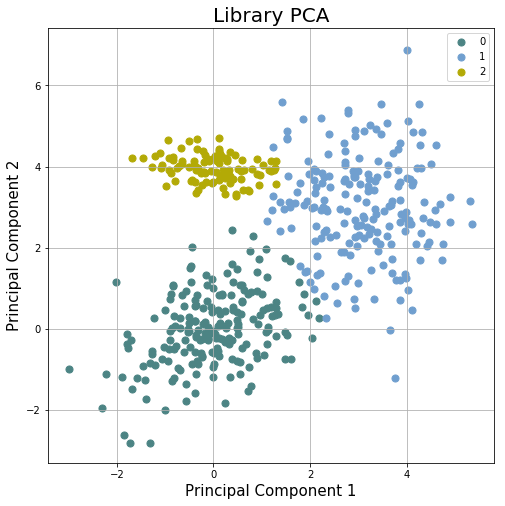

In [15]:
finalDf, gmm_cluster_X = scratchGmm_NoPCA(clu, maximum_iterations, gmm_X, threshold, smoothing, True, mu , sigma , pi)

drawGraph(finalDf, 3)
JaccardRand(gmm_cluster, gmm_cluster_X)

In [12]:
gmm = pd.read_csv('GMM.txt', header = None, delimiter=" ")
gmm_cluster = gmm[1]
gmm_X = gmm.iloc[:, 2:]
gmm_X = gmm_X.to_numpy()
gmm_cluster = gmm_cluster.to_numpy()

Iteration: 0 Loss: -1757.503624
Iteration: 10 Loss: -1747.504312
Iteration: 20 Loss: -1747.504216
Loss below threshold. Iteration: 26 Loss: -1747.504216
Model Sigma:
[[[ 0.46060233 -0.06042128]
  [-0.06042128  0.10632475]]

 [[ 0.92966979  0.3793336 ]
  [ 0.3793336   0.84678293]]

 [[ 0.96221859 -0.03619226]
  [-0.03619226  1.60613534]]]
Model Pi:
[0.19998815 0.40371744 0.39629441]
Model mu:
[[-1.70371854e-02  3.95338988e+00]
 [ 8.52024881e-03 -2.37301349e-03]
 [ 3.03125709e+00  3.00615974e+00]]


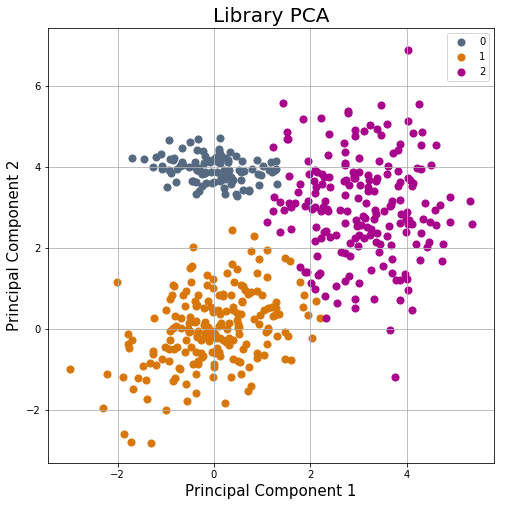

In [38]:
finalDf, gmm_cluster_X = scratchGmm_NoPCA(3, 100, gmm_X, 1e-08)

drawGraph(finalDf, 3)

In [39]:
JaccardRand(gmm_cluster, gmm_cluster_X)

The RAND coefficient is: 0.95208
The JACCARD coefficient is: 0.8733561672798004
